In [54]:
from datasets import load_dataset
import transformers
from tqdm import tqdm
import torch
from symbxai.lrp.symbolic_xai import BERTSymbXAI
from symbxai.model.transformer import bert_base_uncased_model
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import matplotlib.cm
from tqdm import tqdm

### Set up model, tokenizer, and dataset

In [2]:
dataset = load_dataset("movie_rationales")

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")


# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-imdb'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

### SymbolicXAI 

In [4]:
def find_sub_list(sl,l):
    results=[]
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            results.append((ind,ind+sll-1))

    return results

In [9]:
acc = 0
positives_subset = {}
negatives_subset = {}
positives_or = {}
negatives_or = {}

for i in tqdm(range(len(dataset['validation']))):
    text = dataset['validation']['review'][i]
    label = dataset['validation']['label'][i]
    evidences = dataset['validation']['evidences'][i]
    target = label
    
    sample = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_token_type_ids=True,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True
    )
    words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
    
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]
    token_type_ids = sample["token_type_ids"]
    
    logits = model(**sample)['logits']
    prediction = logits.argmax()
    if prediction == target:
        acc += 1
        target = torch.tensor([-1, 1])
        
        
        symbxai_transformer = BERTSymbXAI(sample, target, model, pretrained_embeddings, use_lrp_layers=True)

        R_full = symbxai_transformer.subgraph_relevance(subgraph=symbxai_transformer.node_domain).item()
        
        for _, ev in enumerate(evidences):
            x = tokenizer.encode_plus(
                    ev,
                    add_special_tokens=True,
                    return_token_type_ids=True,
                    pad_to_max_length=False,
                    return_attention_mask=True,
                    return_tensors='pt',
                    truncation = True
            )
            
            evidence = tokenizer.convert_ids_to_tokens(x['input_ids'].squeeze())[1:-1]
            idx = find_sub_list(evidence, words)
            
            if idx != []:
                start, end = idx[0]
                subgraph = list(range(start, end+1))

                R_ev_sub = symbxai_transformer.subgraph_relevance(subgraph=subgraph).item()
                R_ev_or = symbxai_transformer.symb_or(subgraph).item()

                if 1 - label == 0:  # Positive
                    positives_subset[R_ev_sub] = R_full
                    positives_or[R_ev_or] = R_full
                else:
                    negatives_subset[R_ev_sub] = R_full
                    negatives_or[R_ev_or] = R_full

print("Top-1 acc: {}".format(acc / len(dataset['validation'])))

100%|███████████████████████████████████████| 200/200 [1:24:22<00:00, 25.31s/it]

Top-1 acc: 0.855


### Visualization

In [19]:
np.random.seed(0)

ys_pos_or = np.array(list(positives_or.keys()))
xs_pos_or = np.random.normal(2, 0.1, ys_pos_or.shape[0])

ys_neg_or = np.array(list(negatives_or.keys()))
xs_neg_or = np.random.normal(1, 0.1, ys_neg_or.shape[0])

In [20]:
ys_pos_sub = np.array(list(positives_subset.keys()))
xs_pos_sub = np.random.normal(2, 0.1, ys_pos_sub.shape[0])

ys_neg_sub = np.array(list(negatives_subset.keys()))
xs_neg_sub = np.random.normal(1, 0.1, ys_neg_sub.shape[0])

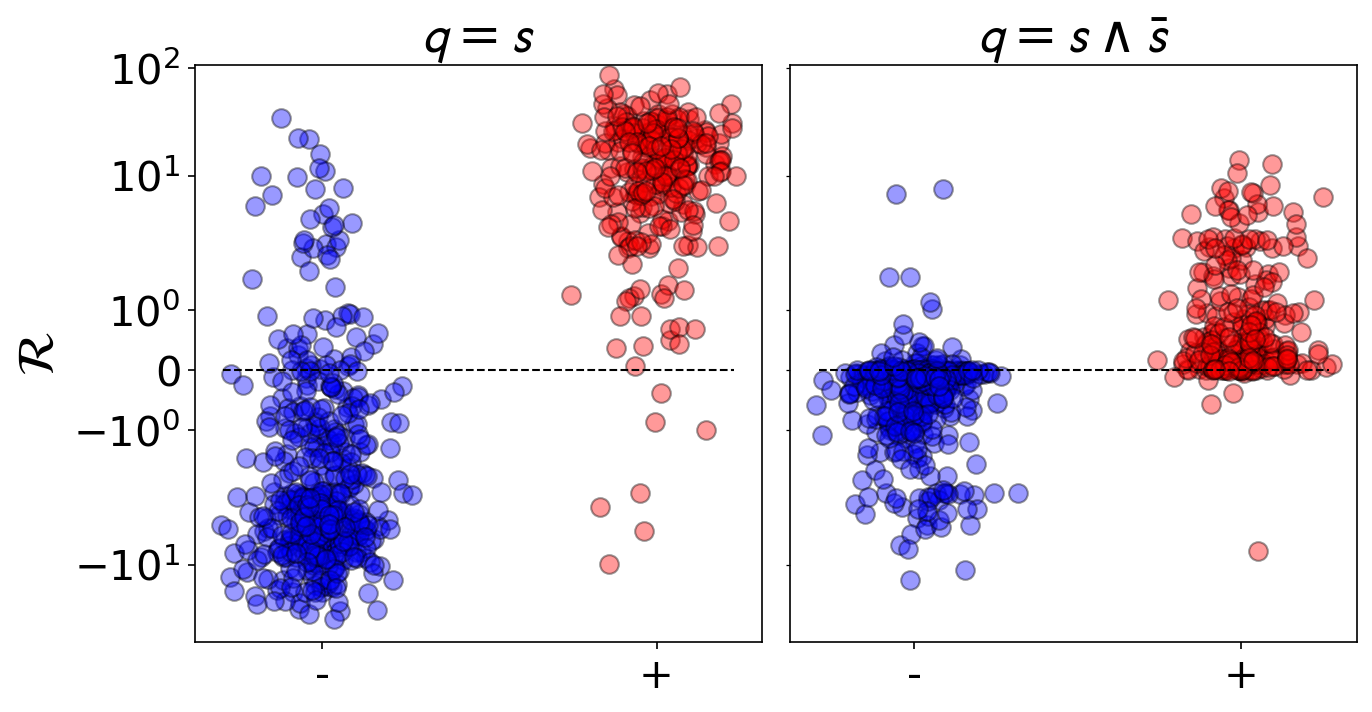

In [69]:
plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 5))
axs[0].scatter(xs_pos_or, ys_pos_or, alpha=.4, edgecolors='black', color='red', s=80)
axs[0].scatter(xs_neg_or, ys_neg_or, alpha=.4, edgecolors='black', color='blue', s=80)
axs[0].set_title('$\\mathcal{q} = \\mathcal{s}$', size=25)
axs[0].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
axs[0].set_ylabel("$\\mathcal{R}$", size=25)
axs[0].set_xticks([1, 2], ['-', '+'], size=20)
axs[0].set_yscale('symlog')

axs[1].scatter(xs_pos_sub, ys_pos_sub, alpha=.4, edgecolors='black', color='red', s=80)
axs[1].scatter(xs_neg_sub, ys_neg_sub, alpha=.4, edgecolors='black', color='blue', s=80)
axs[1].set_title('$\\mathcal{q} = \\mathcal{s} \\wedge \\bar{\\mathcal{s}}$', size=25)
axs[1].axhline(y=0, xmin=0.05, xmax=0.95, color='black', ls='--', linewidth=1)
lim = np.array(list(axs[1].get_ylim())) + np.array(list(axs[0].get_ylim()))
axs[0].set_ylim(lim)
axs[1].set_ylim(lim)
axs[1].set_yscale('symlog')
axs[1].set_xticks([1, 2], ['-', '+'], size=20)
axs[1].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

In [62]:
i = 186
text = dataset['validation']['review'][i]
label = dataset['validation']['label'][i]

print(text)
print('\nLabel: ' + 'Negative' if label == 0 else '\nLabel: ' + 'Positive')
evidences = dataset['validation']['evidences'][i]

target = torch.nn.functional.one_hot(
    torch.tensor(label), num_classes=2)

target = torch.tensor([-1, 1])

sample = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    truncation = True
)
words = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())

bob the happy bastard 's quickie review :
the mummy brendan fraser 's stuck in the past again , but at least this time he has something better to do than to quote sitcom lines and try to woo alicia silverstone .
. .
fraser is the lead star of the mummy , the second directorial effort from action director stephen sommers ( who also brought us the decent thrill ride that was deep rising ) .
it 's a rough adaptation of the 1932 film , and i say rough because it focuses more on special effects than on some guy in bandages , like boris karloff was engulfed in .
but who cares ,
the movie has a sort of swashbuckling quality to it
you ca n't get from , oh , say , godzilla or armageddon .
fraser plays a soldier who gets a premonition during a battle with soldiers in an egyptian ground .
basically , it 's a little sign from the mummy buried underneath- a priest named ihmoetep who was buried alive for taking part of murdering the king and making out with his mistress .
his plan- wake back up and 

In [59]:
# Create model.
model = bert_base_uncased_model(
    pretrained_model_name_or_path='textattack/bert-base-uncased-imdb'
)
model.eval()
pretrained_embeddings = model.bert.embeddings

symbxai_transformer = BERTSymbXAI(sample, target, model, pretrained_embeddings)

In [60]:
symbxai_transformer = BERTSymbXAI(sample, target, model, pretrained_embeddings)

tokenized_evidences = []
for i, ev in enumerate(evidences):
    x = tokenizer.encode_plus(
            ev,
            add_special_tokens=True,
            return_token_type_ids=True,
            pad_to_max_length=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation = True
    )

    tokenized_evidences.append(tokenizer.convert_ids_to_tokens(x['input_ids'].squeeze())[1:-1])
    print(tokenized_evidences[i])

['the', 'special', 'effects', 'from', 'industrial', 'light', 'and', 'magic', 'are', 'top', 'notch']
['entertaining']
['the', 'action', 'is', 'pretty', 'intense']
['the', 'movie', 'has', 'a', 'sort', 'of', 'sw', '##ash', '##buck', '##ling', 'quality', 'to', 'it']
['if', 'you', "'", 're', 'looking', 'for', 'a', 'solid', 'warm', '-', 'up', 'to', 'the', 'summer', 'movie', 'season', ',', 'you', 'wo', 'n', "'", 't', 'find', 'a', 'better', 'film', 'under', 'wraps']


In [61]:
R_values_sub = []
R_values_or = []
for ev in tqdm(tokenized_evidences):
    start, end = find_sub_list(ev, words)[0]
    subgraph = list(range(start, end+1))

    R_ev_sub = symbxai_transformer.subgraph_relevance(subgraph=subgraph, from_walks=False)
    R_ev_or = symbxai_transformer.symb_or(featset=subgraph)
    
    R_values_sub.append(R_ev_sub.numpy())
    R_values_or.append(R_ev_or.numpy())

100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.16s/it]


[ 0.         29.23179438]


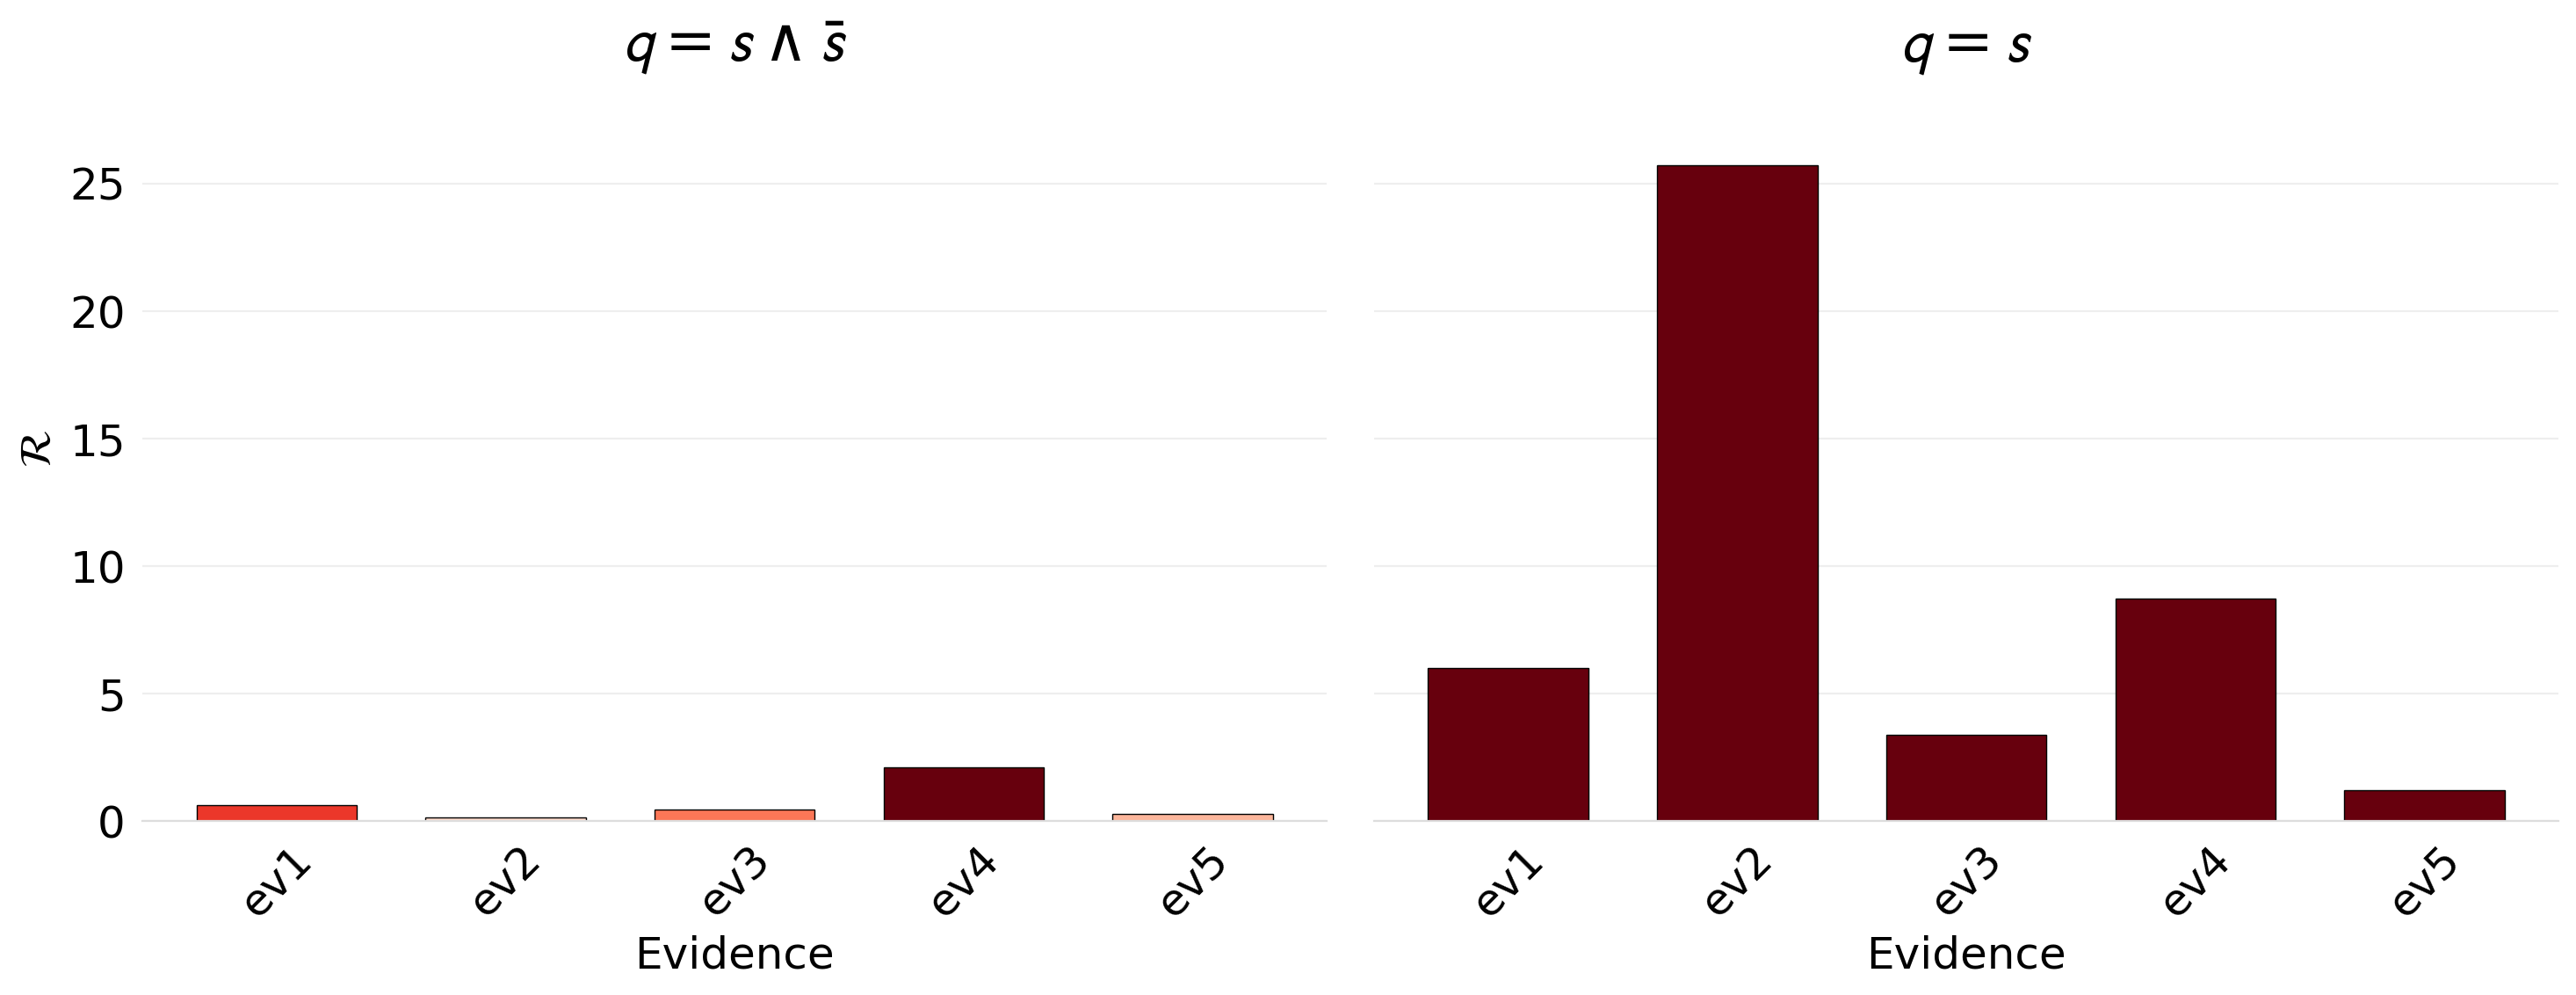

In [68]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'hatch.linewidth': 0.5})
cmap_neg = matplotlib.cm.get_cmap('Blues')
cmap_pos = matplotlib.cm.get_cmap('Reds')

width=0.7
alpha = 1
labels = ['ev{}'.format(i+1) for i in range(len(R_values_sub))]
fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=200)
for i, value in enumerate(R_values_sub):
    if i == 0:
        label = 'Minimal'
    else:
        label = None
        
    if value < 0:
        if label:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5)
    else:
        if label:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[0].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5)

for i, value in enumerate(R_values_or):
    if i == 0:
        label = 'Full'
    else:
        label = None
        
    if value < 0:
        if label:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_neg(abs(value)), width=width, linewidth=0.5)
    else:
        if label:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                          color=cmap_pos(abs(value)), width=width, linewidth=0.5, label=label)
        else:
            bars = ax[1].bar(i, value, alpha=alpha, edgecolor='black',
                      color=cmap_pos(abs(value)), width=width, linewidth=0.5)


for i in range(2):
    ax[i].set_xticks(np.arange(len(R_values_sub)), labels, rotation=45)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_color('#DDDDDD')
    ax[i].tick_params(bottom=False, left=False)
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True, color='#EEEEEE')
    ax[i].xaxis.grid(False)
    
    if i == 0:
        ax[i].set_ylabel('$\\mathcal{R}$')
    else:
        # pass
        ax[i].set_yticklabels([])
    ax[i].set_xlabel('Evidence')
    ax[i].set_facecolor("white")


ax[0].set_title('$\\mathcal{q} = \\mathcal{s} \\wedge \\bar{\\mathcal{s}}$', size=25)
ax[1].set_title('$\\mathcal{q} = \\mathcal{s}$', size=25)

lim = np.array(list(ax[1].get_ylim())) + np.array(list(ax[0].get_ylim()))
print(lim)
ax[0].set_ylim(lim)
ax[1].set_ylim(lim)

plt.tight_layout()
plt.show()